In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-08-17 09:42:08,134	INFO worker.py:1636 -- Started a local Ray instance.


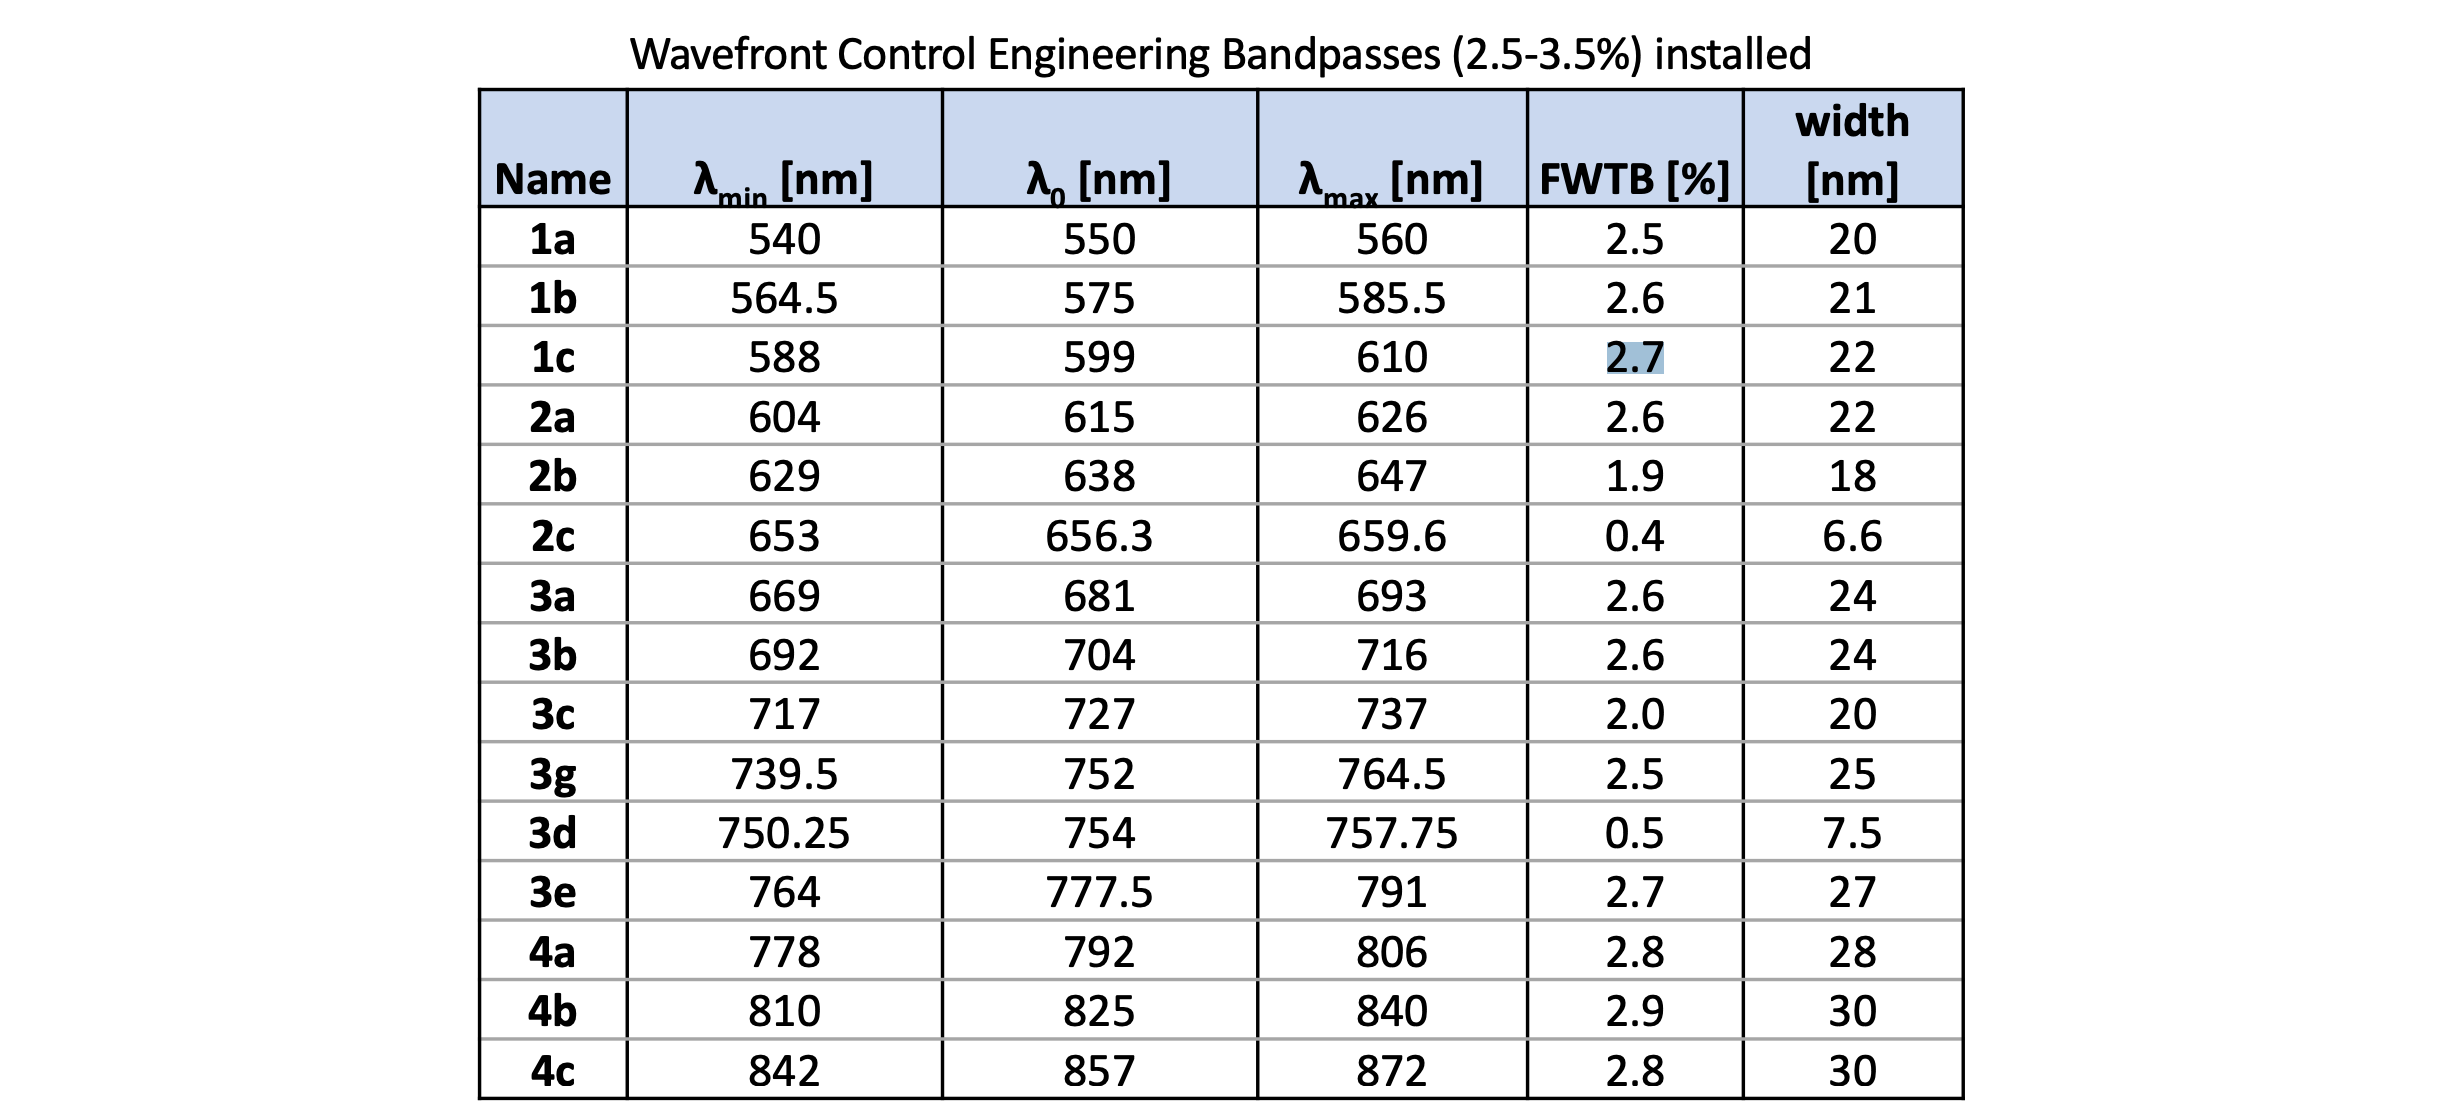

1.0521514041110076e-09 rad
3.4778139958039974e-18 sr
[1.02065396e+08 9.80316512e+07 9.42070350e+07] ph / (s m2)
294304082.0014217 ph / (s m2)


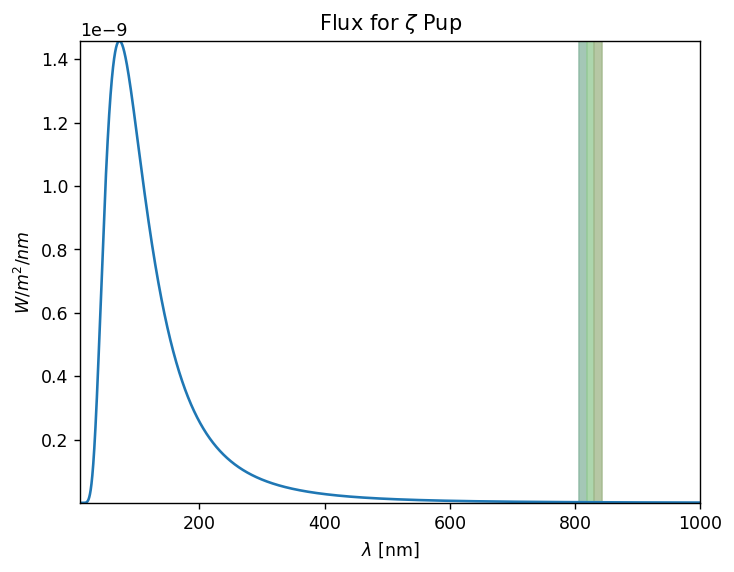

In [2]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 825e-9*u.m

nlam = 3
bandwidth = 2.9/100
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Pup', 
                                            lambdas=np.linspace(10, 1000, 19801)*u.nm,
                                           )

zpup.plot_spectrum()
# zpup.plot_spectrum_ph()

source_fluxes = zpup.calc_fluxes()
print(source_fluxes)
total_flux = np.sum(source_fluxes)
print(total_flux)

In [3]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':148,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':10,
}

actors = []
for i in range(nlam):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

In [4]:
!nvidia-smi

Wed Aug  9 19:45:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:25:00.0 Off |                    0 |
| N/A   30C    P0               63W / 300W|   1663MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

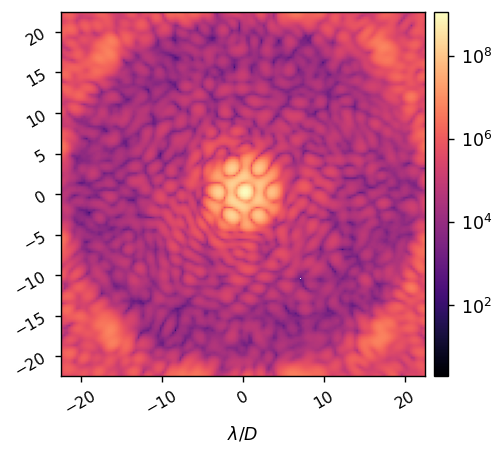

1115617843.0


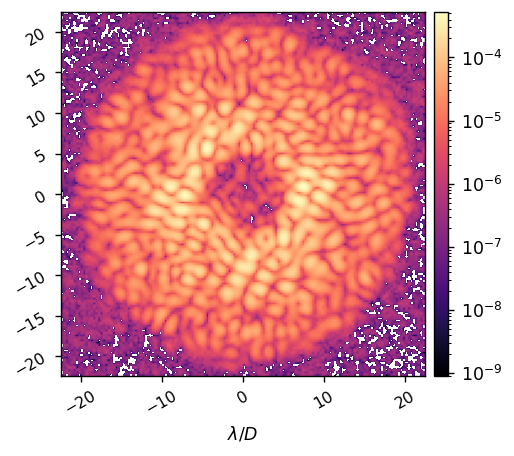

In [4]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.use_noise = True
mode.exp_time = 2*u.s
mode.gain = 100
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
# mode.dark_current_rate = 0.0*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix
# mode.read_noise = 0*u.electron/u.pix

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref
mode.exp_time_ref = mode.exp_time
mode.gain_ref = mode.gain

mode.exp_time = 2*u.s
mode.gain = 100

ref_im = mode.snap()
imshow1(ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

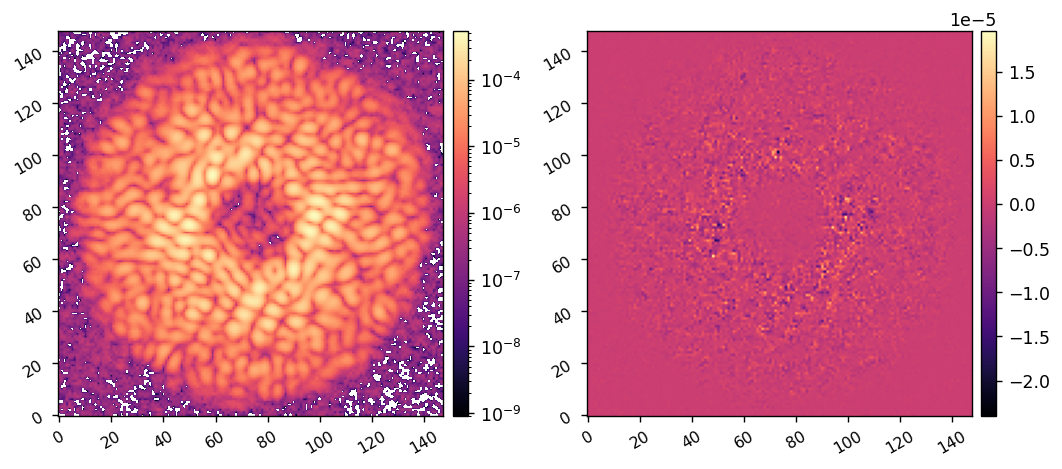

In [6]:
mode.exp_time = 2*u.s
mode.gain = 100
new_im = mode.snap()
imshow2(new_im, ref_im - new_im, lognorm1=True)

# Create dark hole ROI to calibrate and control

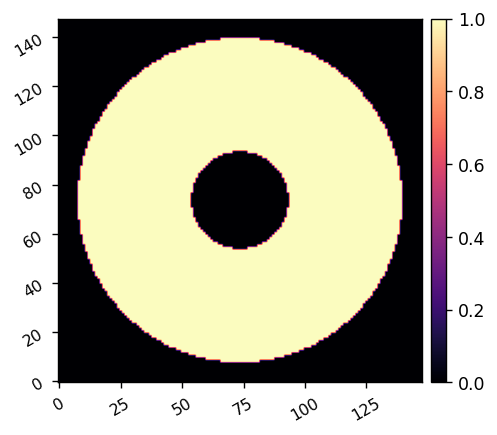

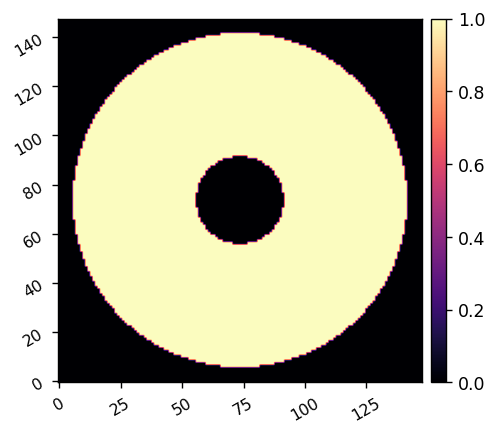

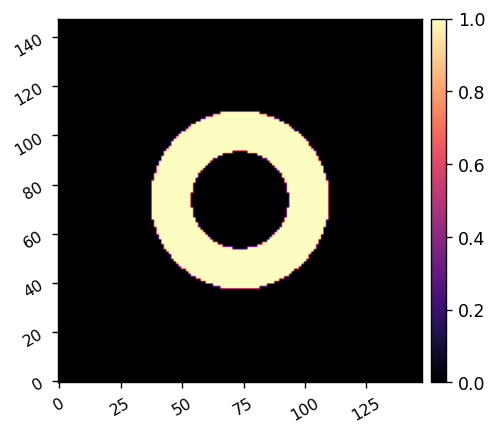

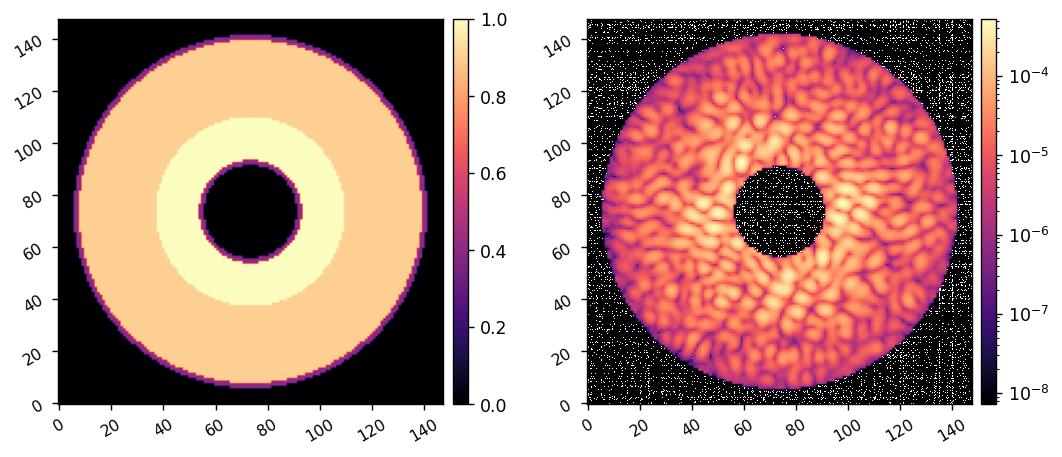

3.0423107060868827e-05


In [5]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create calibration and probe modes

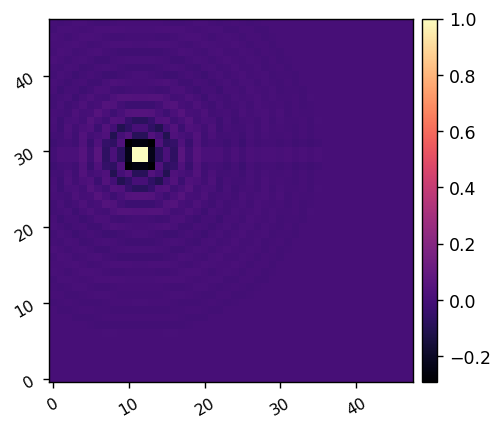

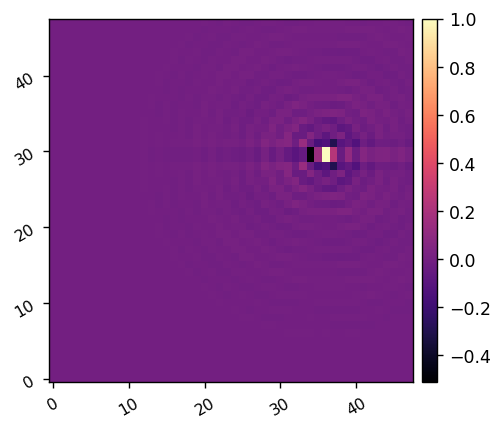

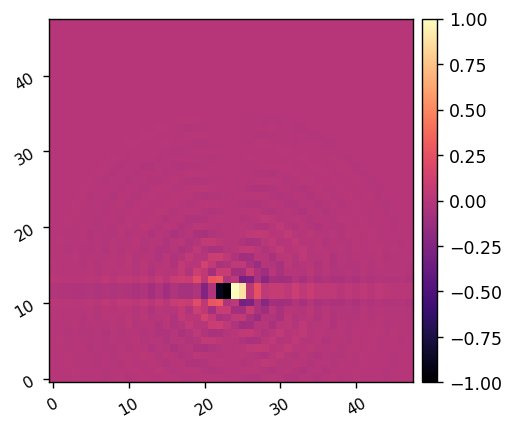

In [51]:
reload(utils)
probe_amp = 2.5e-8
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.2, shift=[(-12,6), (12,6), (0,-12)], nprobes=3, plot=True)


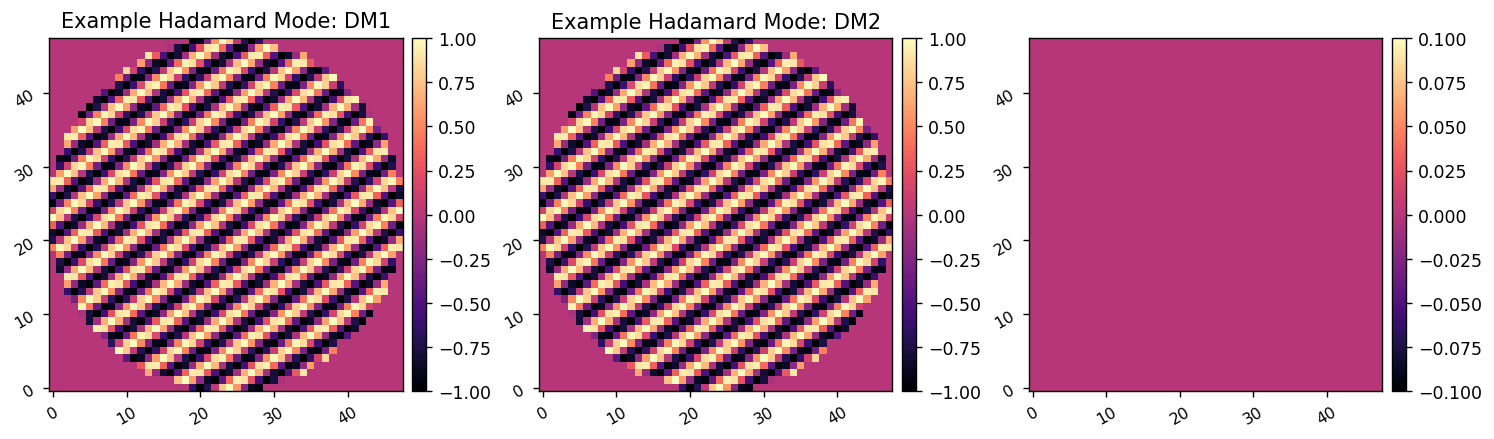

(9040, 4608)

In [50]:
reload(utils)
calib_modes = utils.create_fourier_modes(mode, control_mask, fourier_sampling=0.75, use='both', return_fs=False, ndms=2)

i = 500
imshow3(calib_modes[i][:mode.Nact**2].reshape(mode.Nact,mode.Nact), 
        calib_modes[i+4520][mode.Nact**2:].reshape(mode.Nact,mode.Nact),
        calib_modes[i][:mode.Nact**2].reshape(mode.Nact,mode.Nact) - calib_modes[i+4520][mode.Nact**2:].reshape(mode.Nact,mode.Nact),
        'Example Hadamard Mode: DM1', 'Example Hadamard Mode: DM2')
calib_modes.shape


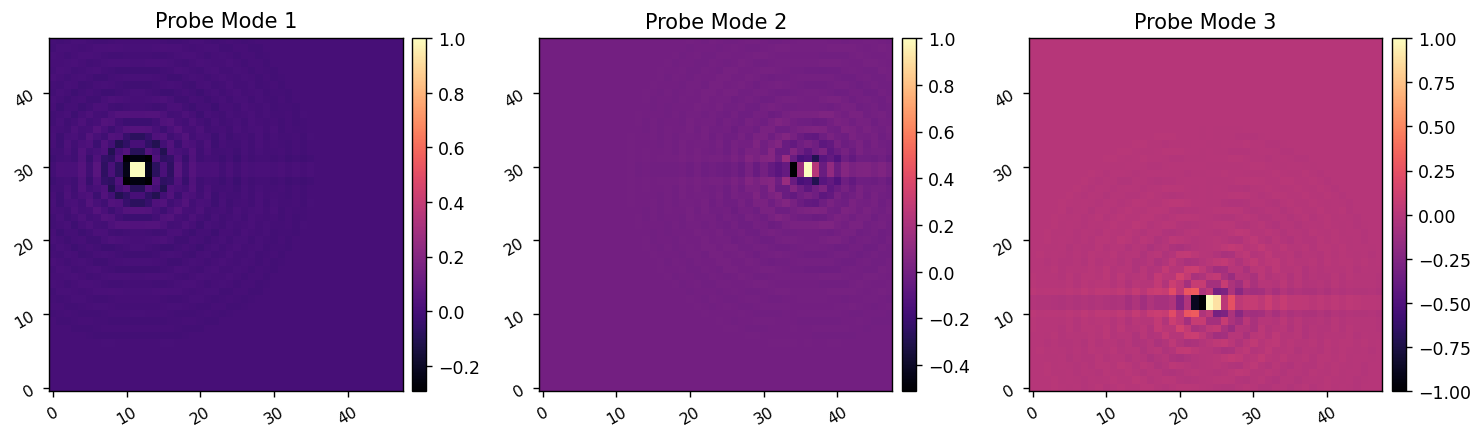

In [8]:
imshow3(probe_modes[0], probe_modes[1], probe_modes[2], 'Probe Mode 1', 'Probe Mode 2', 'Probe Mode 3')

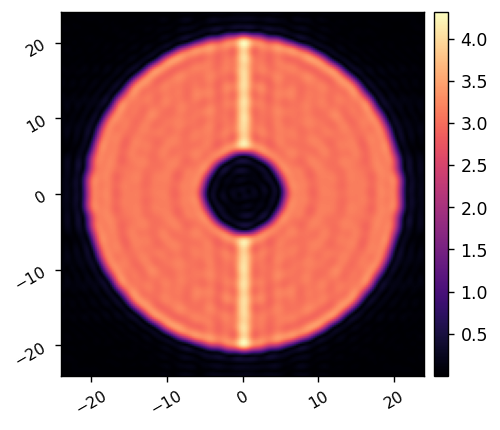

In [10]:
probe_response = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(utils.pad_or_crop(probe_modes[0], 4*mode.Nact)))))
imshow1(probe_response, pxscl=1/4)

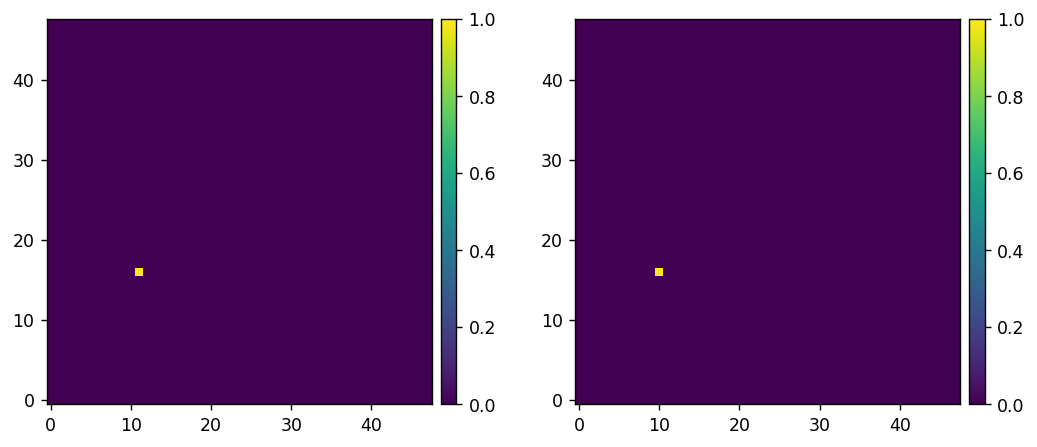

In [8]:
probe_amp = 2.5e-8
probe_modes = utils.create_poke_probes([(mode.Nact//5+2, mode.Nact//3), (mode.Nact//5+1, mode.Nact//3)], plot=True)
# imshow1(probe_modes[0] - probe_modes[1])
# probe_modes = utils.create_poke_probes([(mode.Nact//4, mode.Nact//4), (mode.Nact//2, 3*mode.Nact//4), (3*mode.Nact//4, mode.Nact//4)], plot=True)

In [23]:
calib_amp = 5e-9
calib_modes = utils.create_all_poke_modes(mode.dm_mask, ndms=2)

calib_modes.shape


import time
for i in range(1800,len(calib_modes)):
    try:
        imshow2(calib_modes[i][:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i][mode.Nact**2:].reshape(mode.Nact,mode.Nact))
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

<Figure size 1250x500 with 0 Axes>

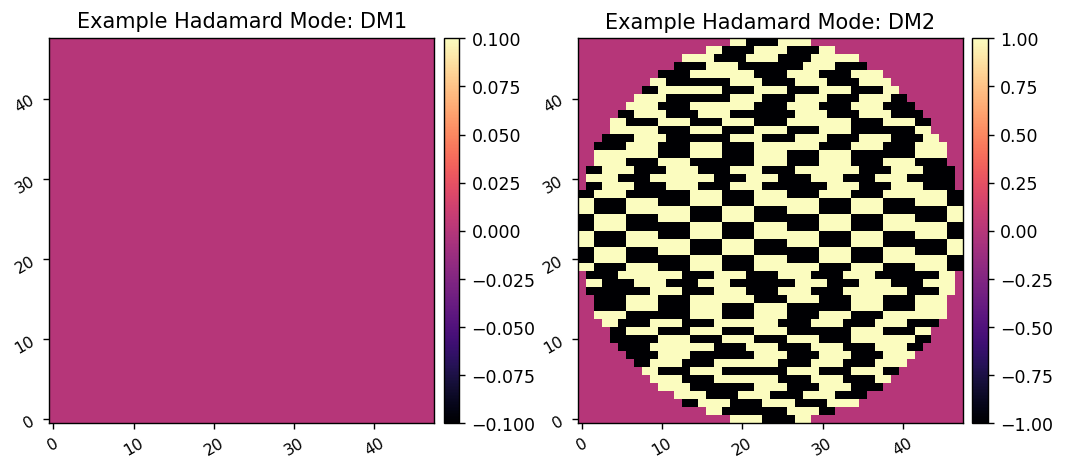

(4096, 4608)

In [52]:
calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)

imshow2(calib_modes[52+2048][:mode.Nact**2].reshape(mode.Nact,mode.Nact), 
        calib_modes[52+2048][mode.Nact**2:].reshape(mode.Nact,mode.Nact),
        'Example Hadamard Mode: DM1', 'Example Hadamard Mode: DM2')
calib_modes.shape

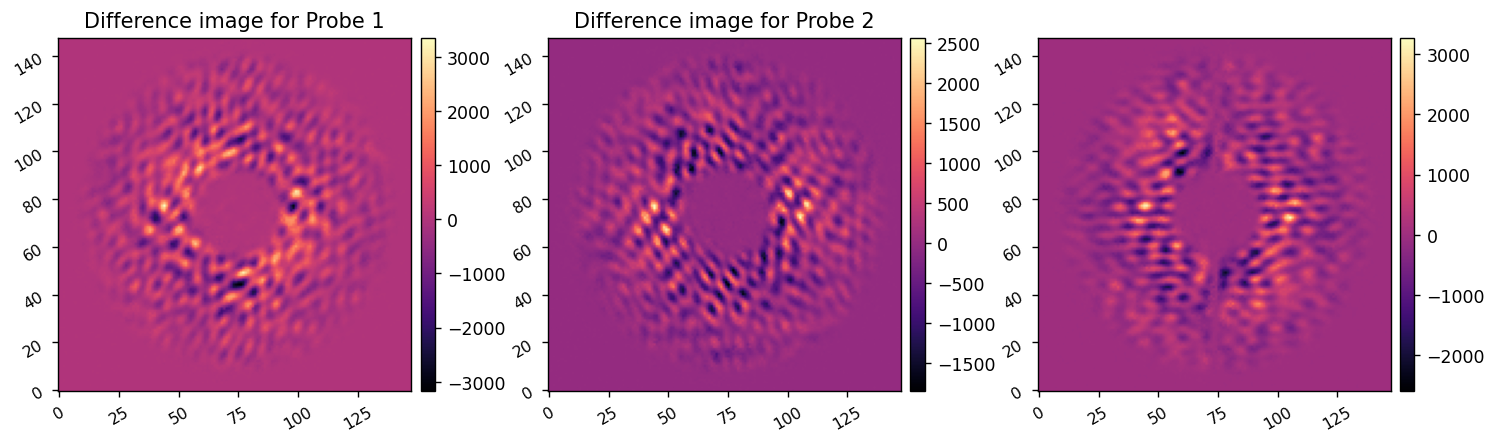

In [53]:
reload(iefc_2dm)

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
imshow3(ims[0], ims[1], ims[2], 'Difference image for Probe 1', 'Difference image for Probe 2')

In [38]:
25*1804/3600

12.527777777777779

In [54]:
reload(iefc_2dm)

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                         calib_amp, calib_modes, 
                                                         return_all=True)


Calibrating iEFC...


KeyboardInterrupt: 

In [10]:
!nvidia-smi

Thu Aug 10 10:12:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:25:00.0 Off |                    0 |
| N/A   31C    P0               63W / 300W|  17345MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [55]:
# date = 20230630
# date = 20230703
# date = 20230713
# date = 20230720
# date = 20230723
# date = 20230804
# date = 20230806
# date = 20230808
# response_matrix = xp.array(fits.getdata(response_dir/f'bbspc_iefc_2dm_poke_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'bbspc_iefc_2dm_poke_response_cube_{date}.fits'))

date = 20230809
response_matrix = xp.array(fits.getdata(response_dir/f'bbspc_iefc_2dm_had_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(data_dir/response_dir/f'bbspc_iefc_2dm_had_response_cube_{date}.fits'))

In [12]:
148**2, 2*control_mask.sum()

(21904, array(27048))

In [25]:
mode.Nacts

1804

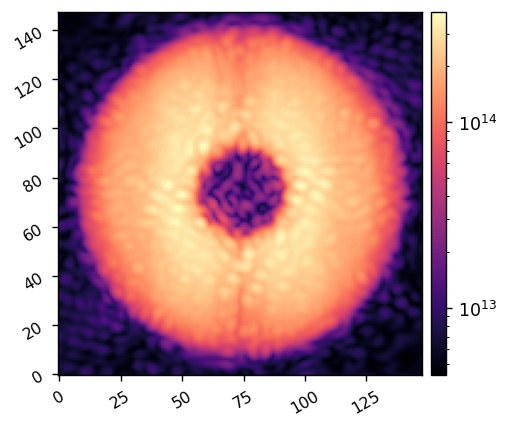

In [56]:
reload(utils)
# dm1_response_sum = utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_matrix)**2, axis=0))[:mode.Nacts], mode.dm_mask)
# dm2_response_sum = utils.map_acts_to_dm(xp.sqrt(xp.sum(abs(response_matrix)**2, axis=0))[mode.Nacts:], mode.dm_mask)
# imshow2(dm1_response_sum , dm2_response_sum, lognorm=True,)

fp_response_sum = xp.sum(abs(response_cube), axis=(0,1)).reshape(mode.npsf, mode.npsf)
imshow1(fp_response_sum, lognorm=True,)

# Run IEFC

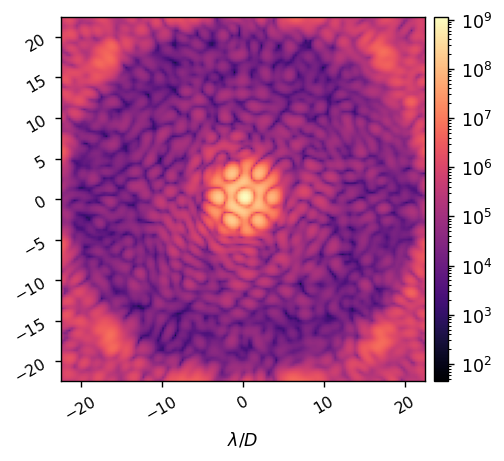

1115210453.4


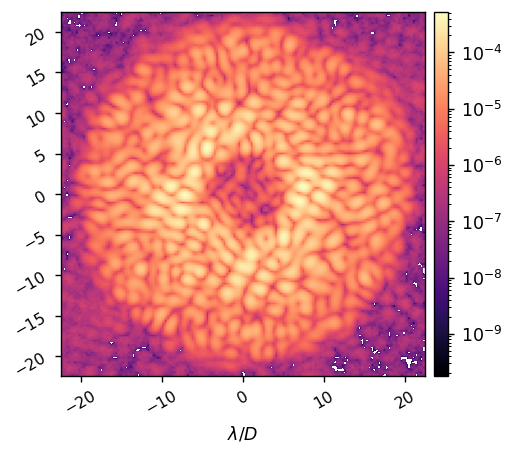

In [57]:
mode.reset_dms()

mode.exp_time = 10*u.s
mode.gain = 100
mode.Imax_ref = None

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref

new_ref_im = mode.snap()
imshow1(new_ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

In [20]:
response_matrix.shape

(40572, 4096)

Running iEFC...
	Closed-loop iteration 1 / 5
(4096,)
(4608,)
	Mean NI of this iteration: 8.448e-06


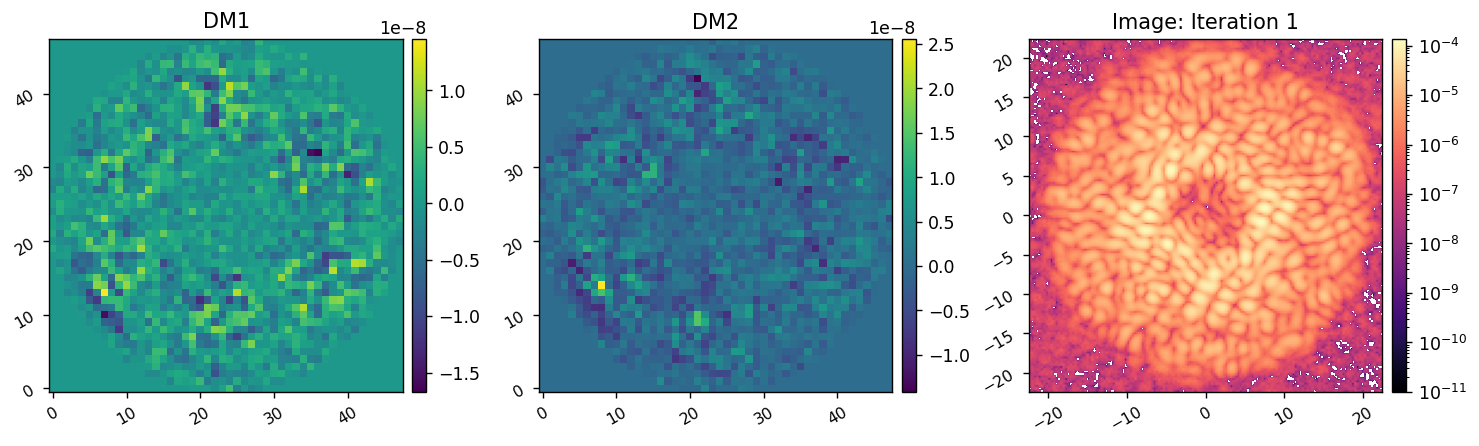

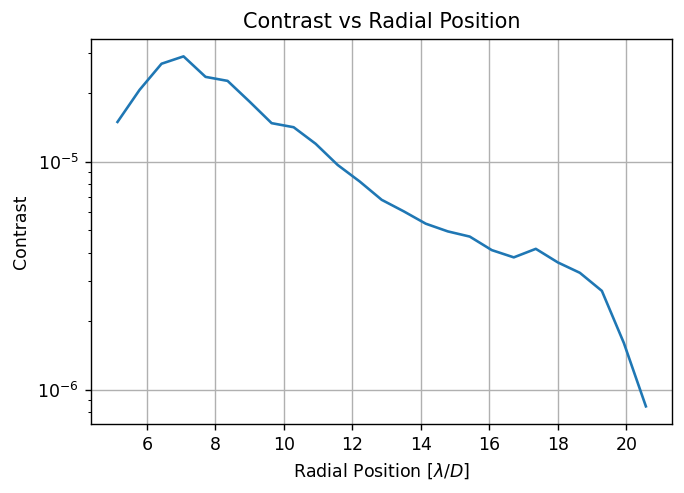

	Closed-loop iteration 2 / 5
(4096,)
(4608,)
	Mean NI of this iteration: 2.659e-06


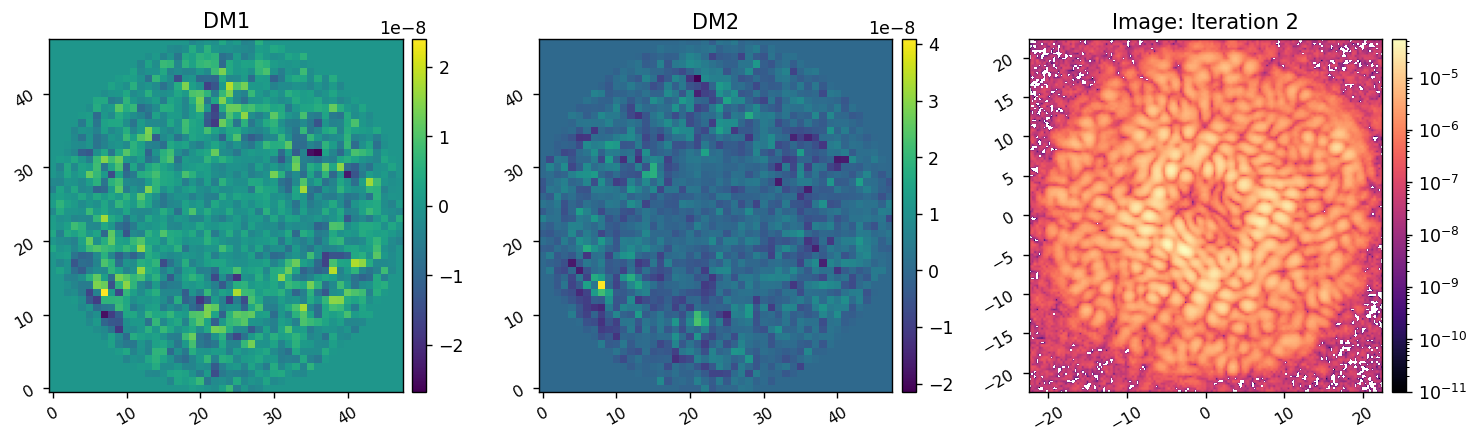

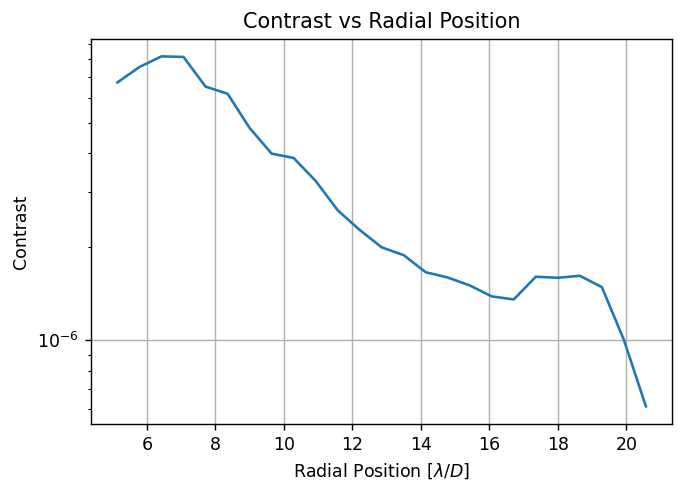

	Closed-loop iteration 3 / 5
(4096,)
(4608,)
	Mean NI of this iteration: 1.078e-06


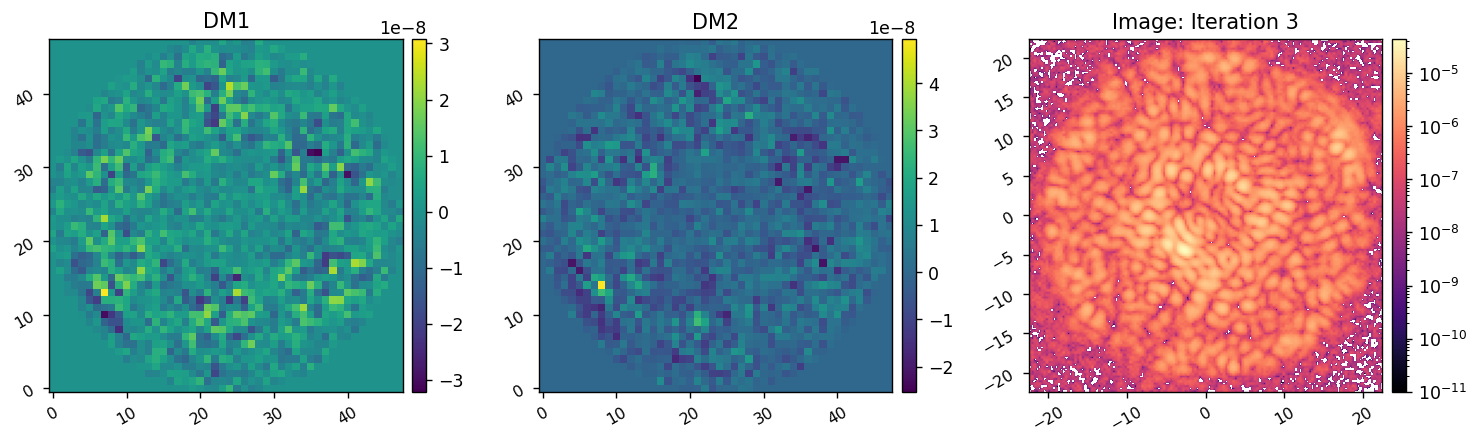

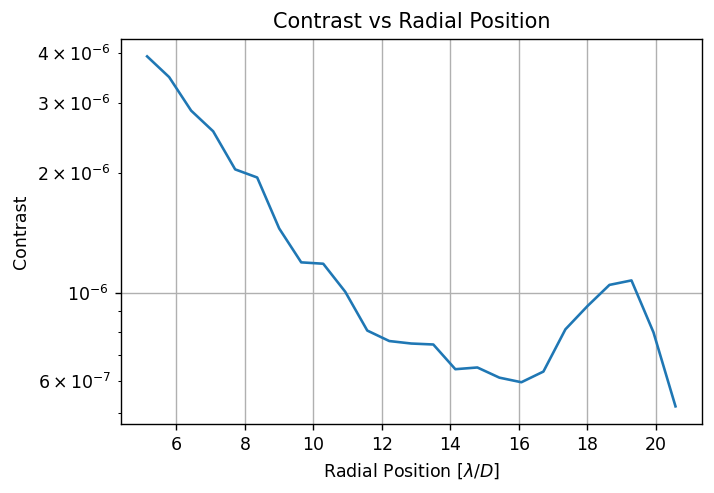

	Closed-loop iteration 4 / 5
(4096,)
(4608,)
	Mean NI of this iteration: 6.073e-07


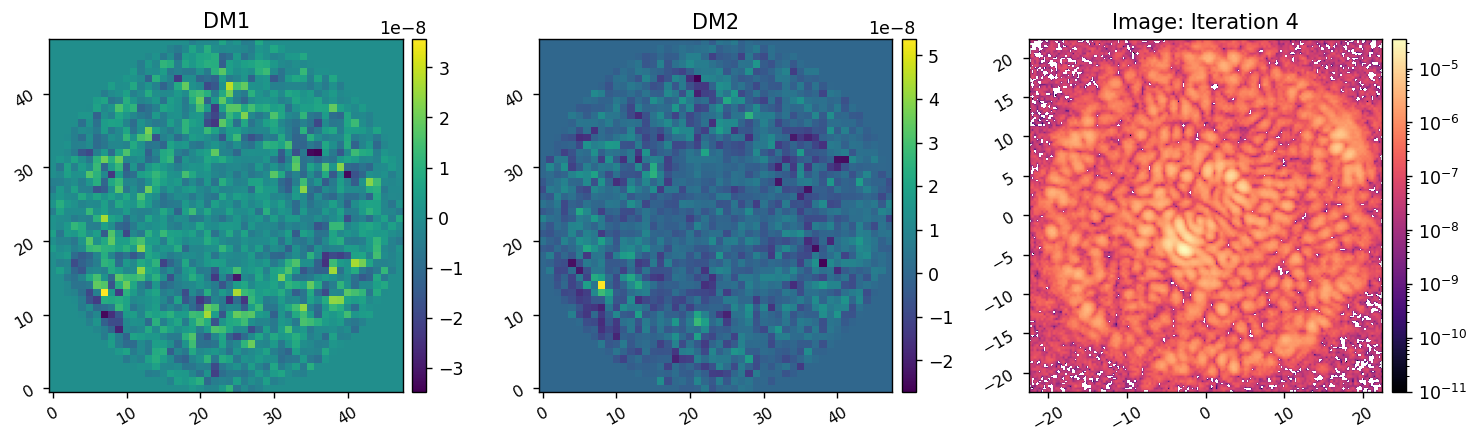

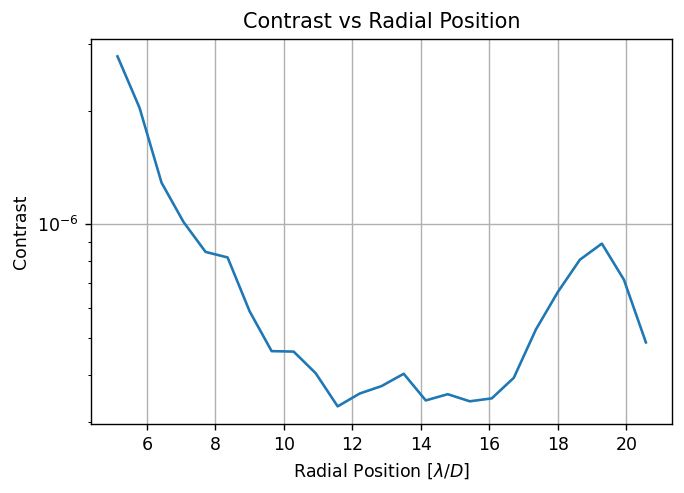

	Closed-loop iteration 5 / 5
(4096,)
(4608,)
	Mean NI of this iteration: 4.380e-07


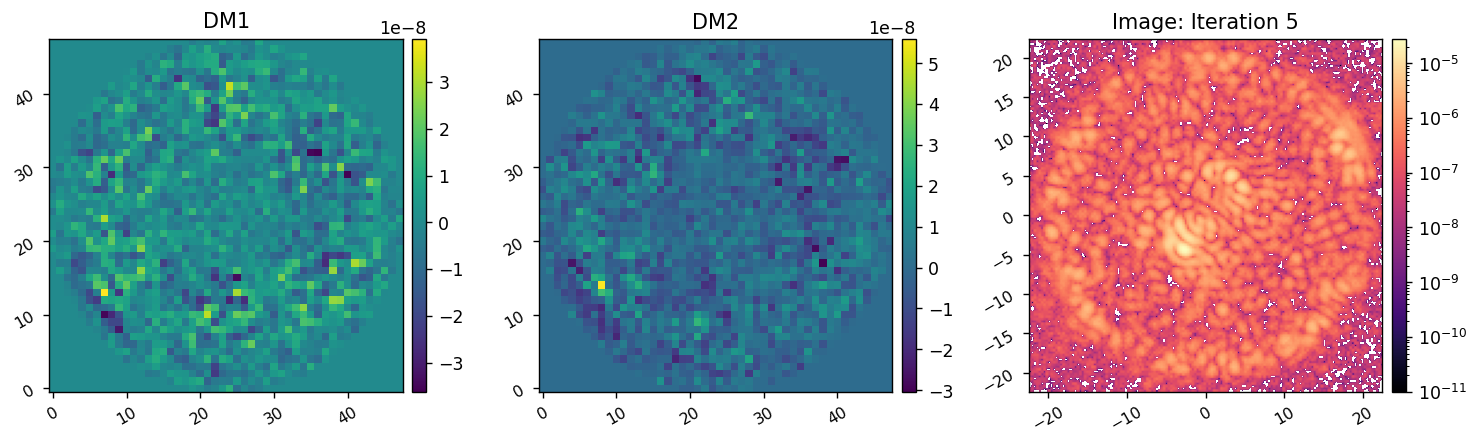

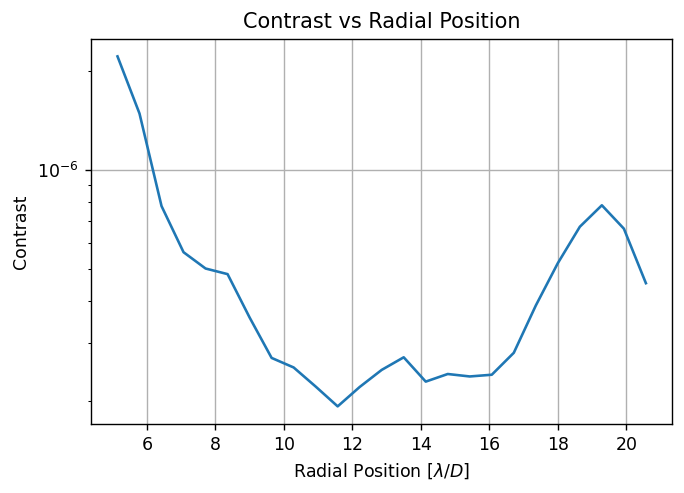

Closed loop for given control matrix completed in 40.377s.


In [59]:
reload(iefc_2dm)
reload(utils)

reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          calib_modes,
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=True
                                         )

In [60]:
calib_modes.shape

(4096, 4608)

Running iEFC...
	Closed-loop iteration 1 / 5
	Mean NI of this iteration: 8.445e-06


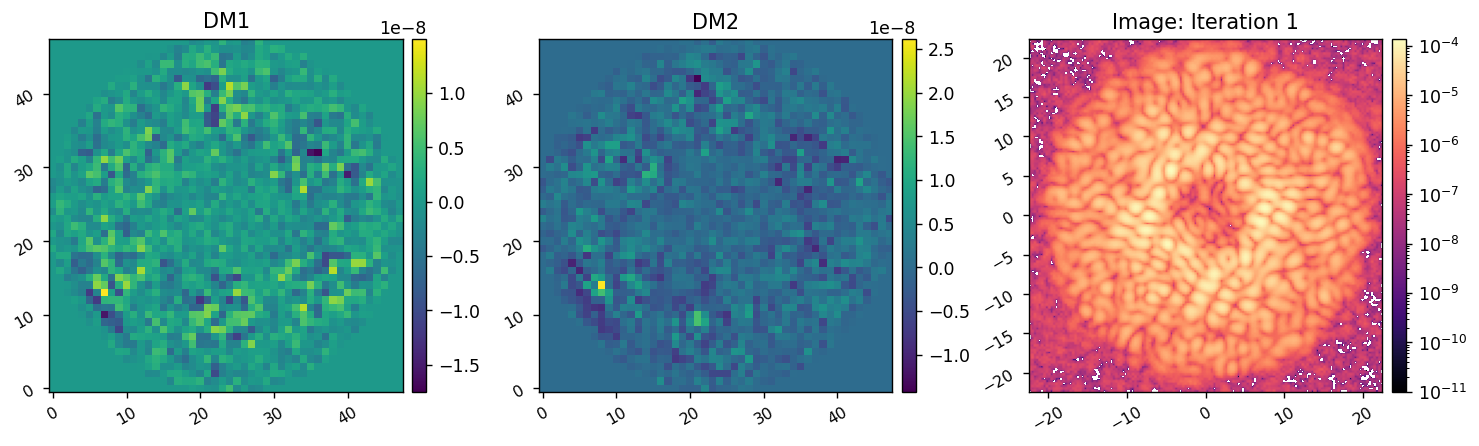

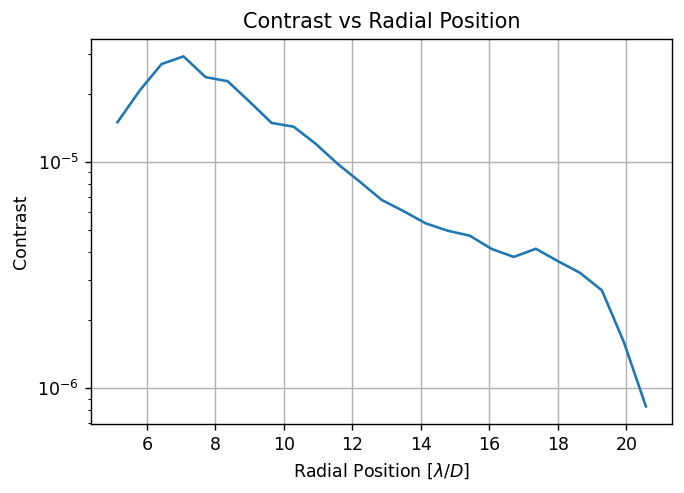

	Closed-loop iteration 2 / 5
	Mean NI of this iteration: 2.656e-06


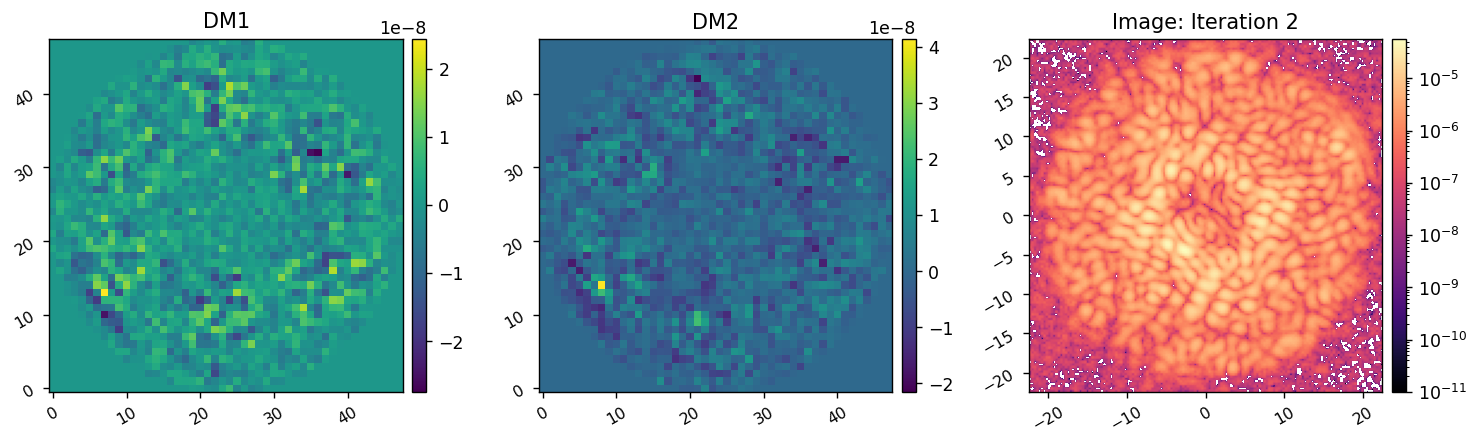

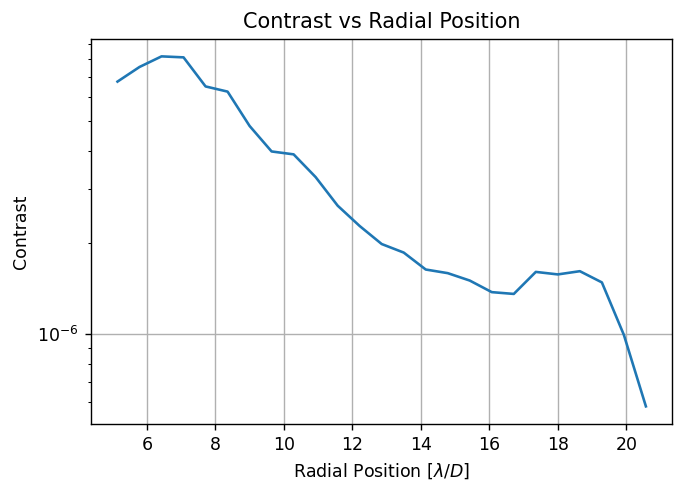

	Closed-loop iteration 3 / 5
	Mean NI of this iteration: 1.082e-06


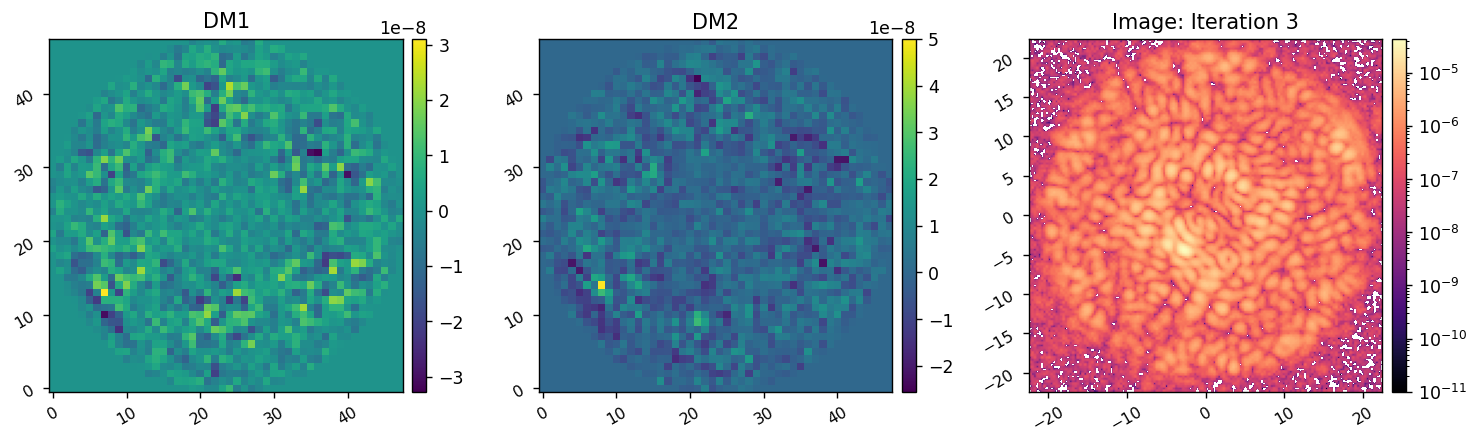

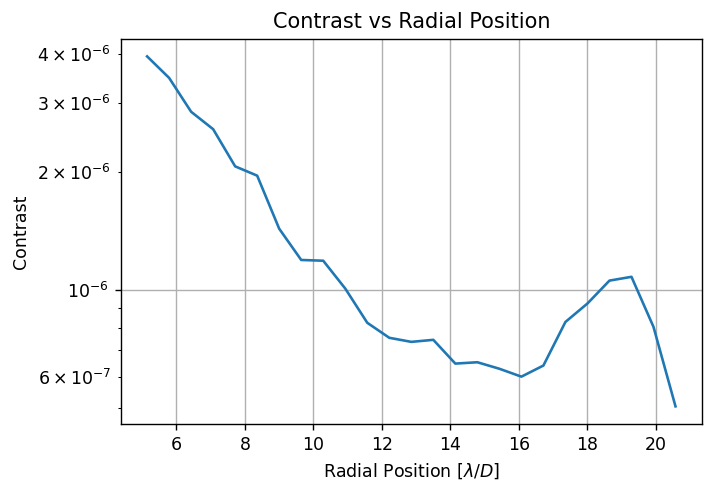

	Closed-loop iteration 4 / 5
	Mean NI of this iteration: 6.065e-07


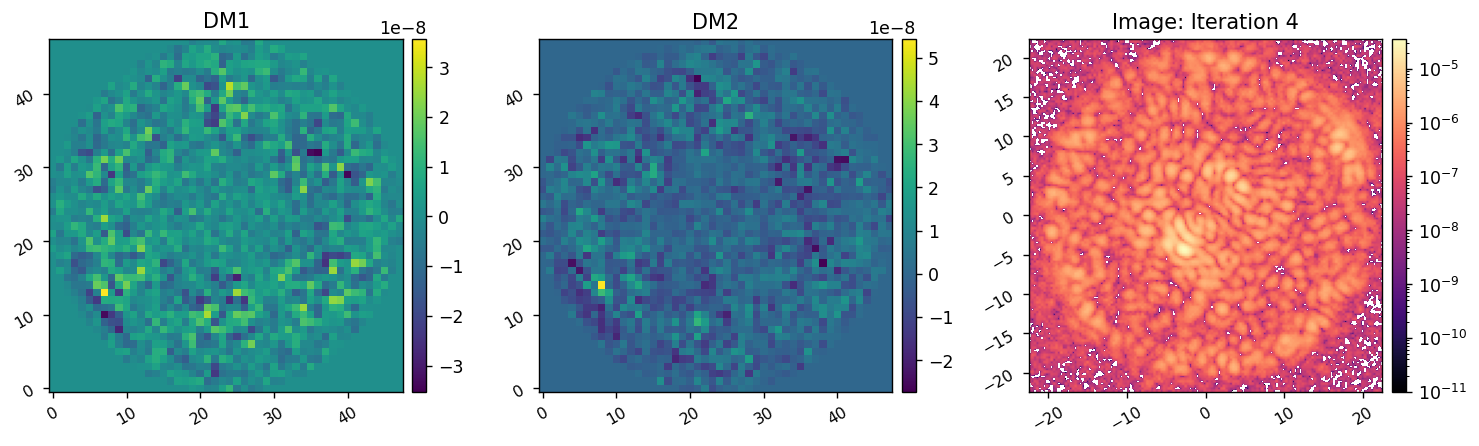

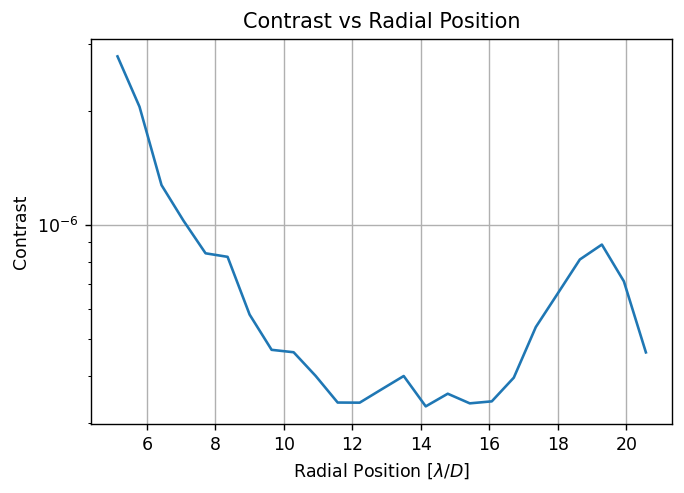

	Closed-loop iteration 5 / 5
	Mean NI of this iteration: 4.381e-07


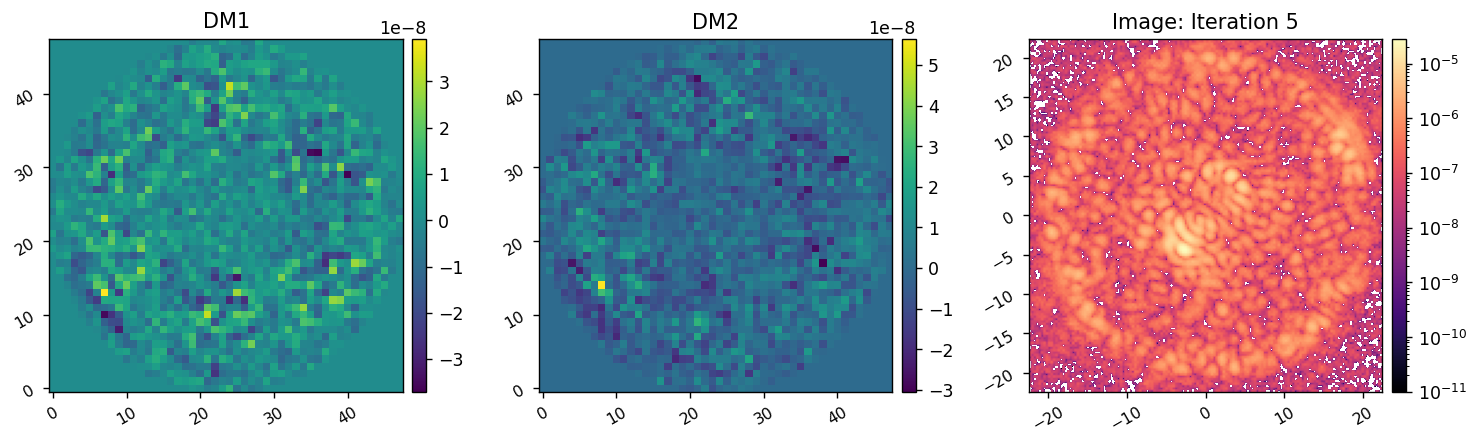

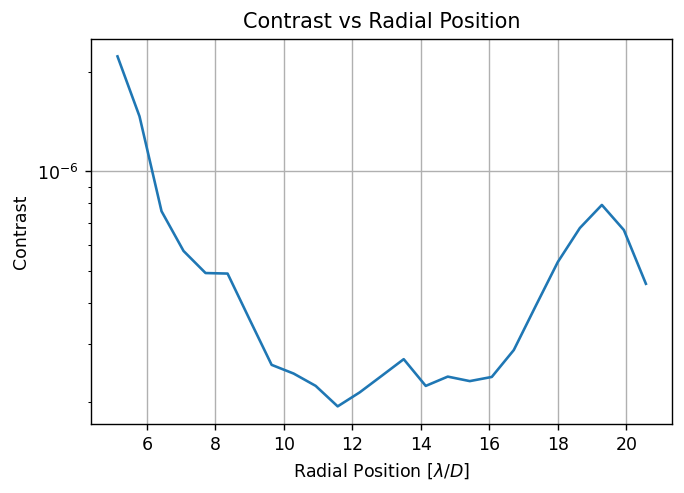

Closed loop for given control matrix completed in 40.447s.


In [18]:
reload(iefc_2dm)
reload(utils)

reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=True
                                         )

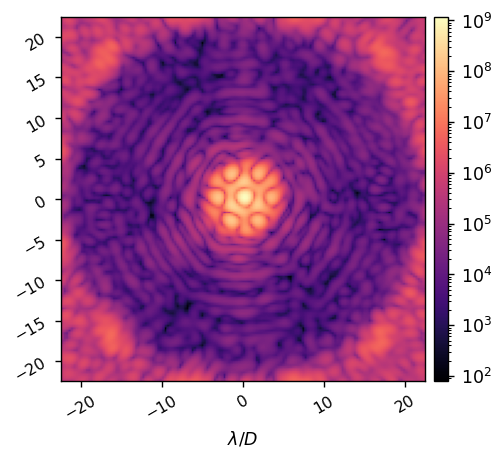

1151645705.75


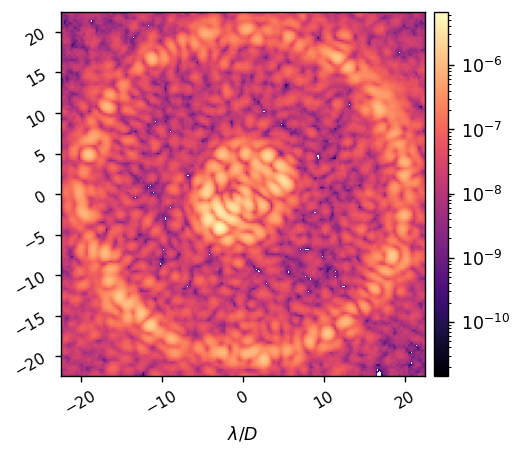

In [33]:
mode.exp_time = 180*u.s
mode.gain = 200
mode.Imax_ref = None

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref

new_ref_im = mode.snap()
imshow1(new_ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

Running iEFC...
	Closed-loop iteration 50 / 50
	Mean NI of this iteration: 9.011e-08


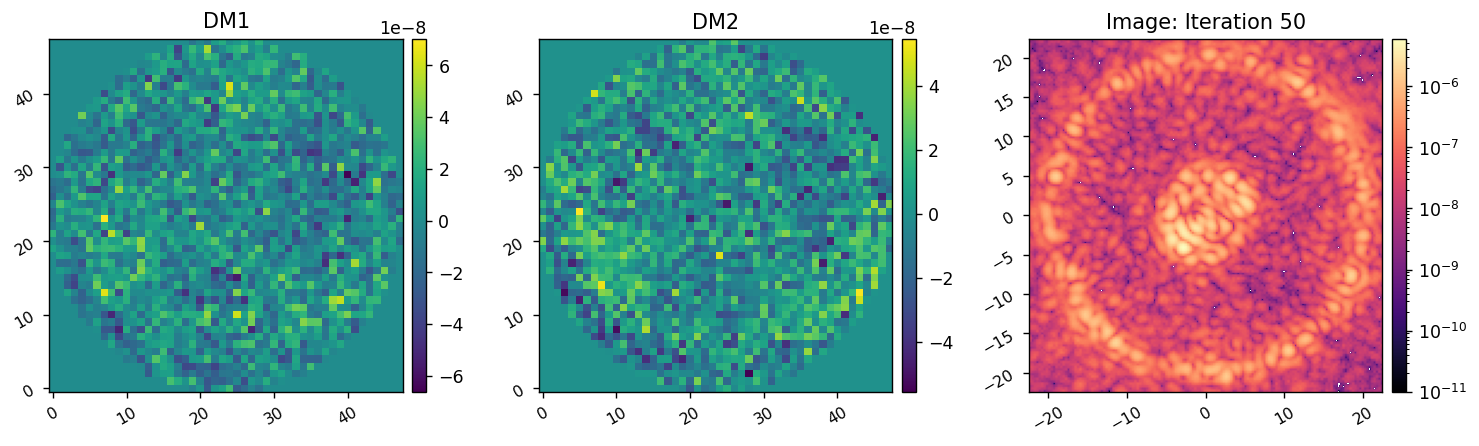

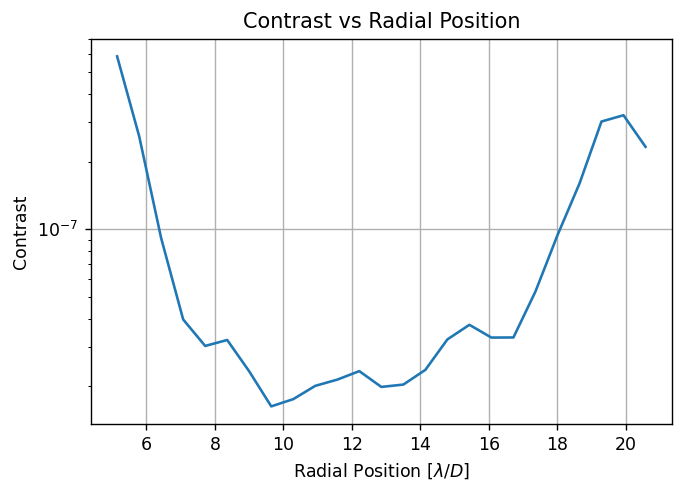

Closed loop for given control matrix completed in 9.547s.


In [39]:
Nitr = 1
reg_cond = 2e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])
        
images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                                  control_matrix,
                                                  probe_modes, 
                                                  probe_amp, 
                                                  ensure_np_array(calib_modes),
                                                  control_mask, 
                                                  num_iterations=Nitr, 
#                                                   starting_iteration=0,
                                                  loop_gain=0.5, 
                                                  leakage=0,
                                                  plot_all=True,
                                                  plot_radial_contrast=True,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                                 )

In [27]:
iefc_2dm.iefc_data_dir

PosixPath('/home/kianmilani/Projects/roman-cgi-iefc-data')

In [29]:
images.shape

(50, 148, 148)

In [30]:
utils.save_fits(iefc_2dm.iefc_data_dir/'images'/f'bbspc_had_modes_images_{date}.fits', images)
utils.save_fits(iefc_2dm.iefc_data_dir/'dm-commands'/f'bbspc_had_modes_dm1_{date}.fits', dm1_commands)
utils.save_fits(iefc_2dm.iefc_data_dir/'dm-commands'/f'bbspc_had_modes_dm2_{date}.fits', dm2_commands)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/images/bbspc_had_modes_images_20230808.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/dm-commands/bbspc_had_modes_dm1_20230808.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/dm-commands/bbspc_had_modes_dm2_20230808.fits


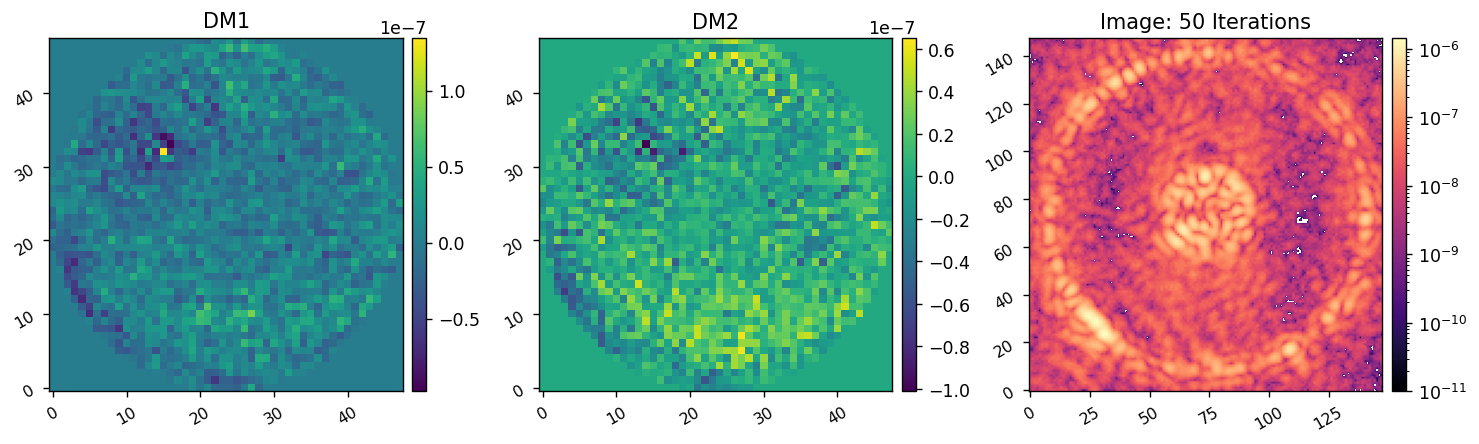

In [41]:
imshow3(dm1_commands[-1], dm2_commands[-1], images[-1], 
        'DM1', 'DM2', 'Image: 50 Iterations',
        cmap1='viridis', cmap2='viridis', lognorm3=True, vmin3=1e-11)